In [1]:
import pandas as pd
import numpy as np
from statsmodels.tools.tools import add_constant

## HINTS
Quando si scrive ```python nome_variabile: type = qualcosa```, quello che viene dopo i ":" e prima di "=" serve solo per specificare la tipologia di oggetto a cui si sta facendo riferimento. Non è necessario specificarlo, ma all'interno di questo Jupyter viene fatto per capire quali sono le trasformazioni che avvengono sugli oggetti.

Per essere sicuri, o comunque per verificare, la tipologia di oggetto risultante da un'operazione, è sufficiente usare la funzione built-in di Python `type()`. Ad esempio, per un oggetto (una variabile) chiama `foo`, basterà scrivere:
```python
type(foo)
```

### IMPORT DATA
usiamo la funzione di pandas `read_excel()` per importare il dataset direttamenet in formato `DataFrame`. Esistono molte funzioni per importare un'enormità di tipi diversi di formati. Provate a digitare `pd.read` e vedrete che il suggeritore vi darà molte opzioni!

**WARNING**: La stringa che dovete inserire dentro la funzione `read_excel()` deve essere il percorso che porta al file e dipende da dove lo avete salvato nel vostro pc. Se non riuscite a trovare il percorso, tasto destro sul nome del file, cliccate su proprietà e troverete il path.

In [3]:
# index_col setta una colonna come index di pd.DataFrame
data: pd.DataFrame = pd.read_excel("~/PycharmProjects\Econometrics-Course\Dataset\stock_index_fx_us.xlsx", index_col="datetime")

## CALC RETURNS

In [4]:
rf = 0.0001
# applica log a data e dopo fa la differenza prima con diff(); dropna() elimina i NaN dal DataFrame
# provare a stampare log_ret con e senza .dropna()
log_ret: pd.DataFrame = np.log(data).diff().dropna()
log_ret.head()

,AAPL,ABI,W5000,SP500,EUR_USD,USD_YEN
datetime,,,,,,
2009-01-05,0.041338,0.098272,-0.022958,-0.004679,0.001071,0.000738
2009-01-06,-0.016632,-0.017332,-0.024068,0.007787,-0.001357,0.001685
2009-01-07,-0.021845,-0.006007,0.003633,-0.030469,-0.011139,0.003467
2009-01-08,0.018399,0.039262,-0.035037,0.003391,0.007129,0.016641
2009-01-09,-0.023135,-0.010968,0.004174,-0.021533,0.015662,-0.016641


In [5]:
log_ret.describe().round(4)

,AAPL,ABI,W5000,SP500,EUR_USD,USD_YEN
count,2767.0000,2767.0000,2767.0000,2767.0000,2767.0000,2767.0000
mean,0.0011,0.0004,0.0005,0.0004,-0.0001,0.0000
std,0.0167,0.0153,0.0105,0.0103,0.0056,0.0058
min,-0.1319,-0.1196,-0.0733,-0.0690,-0.0265,-0.0375
25%,-0.0070,-0.0077,-0.0037,-0.0035,-0.0033,-0.0030
50%,0.0010,0.0003,0.0006,0.0007,0.0000,0.0000
75%,0.0102,0.0087,0.0055,0.0053,0.0030,0.0031
max,0.0850,0.0983,0.0677,0.0684,0.0302,0.0346


DEFINE INPUT FOR REGRESSION

In [6]:
Y: pd.DataFrame = log_ret.loc[:, ["AAPL"]] - rf # usare [] quando si selezionano le colonne per ottenere un pd.DataFrame 
X: pd.DataFrame = log_ret.loc[:, ["SP500", "EUR_USD", "USD_YEN"]]  # seleziona mkt factor e tasso cambio

X.loc[:, "SP500"] = X.loc[:, "SP500"] - rf  # sostituisce mkt factor con mkt factor - risk_free (excess market returns)
# ALTERNATIVA: X.loc["SP500"] -= rf
X = add_constant(X)  # aggiunge una colonna di 1 IN ULTIMA POSIZIONE (la funzione è stata importata all'inizio dalla libreria statsmodel)

C:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [7]:
Y.head()

,AAPL
datetime,
2009-01-05,0.041238
2009-01-06,-0.016732
2009-01-07,-0.021945
2009-01-08,0.018299
2009-01-09,-0.023235


In [8]:
X.head()

,const,SP500,EUR_USD,USD_YEN
datetime,,,,
2009-01-05,1.0,-0.004779,0.001071,0.000738
2009-01-06,1.0,0.007687,-0.001357,0.001685
2009-01-07,1.0,-0.030569,-0.011139,0.003467
2009-01-08,1.0,0.003291,0.007129,0.016641
2009-01-09,1.0,-0.021633,0.015662,-0.016641


CALC REGRESSION'S COEFFICIENTS

In [9]:
coeffs: pd.DataFrame = np.linalg.inv(X.transpose() @ X) @ X.transpose() @ Y
coeffs.index = X.columns  # oltre al matching tra (rows, columns) matriciale; deve matchare anche il nome delle righe con quello delle colonne
coeffs

,AAPL
const,0.000680
SP500,0.994181
EUR_USD,0.029182
USD_YEN,0.055324


In [10]:
Y_hat: pd.DataFrame = X @ coeffs

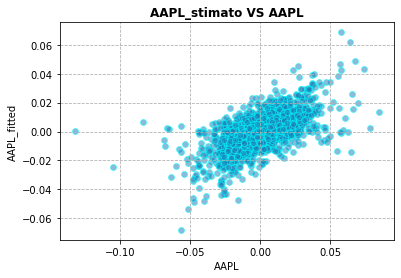

In [11]:
import matplotlib.pyplot as plt  # super estetica, utilizzare libreria seaborn
# per mostrare il grafico all'interno del notebook, se si vuol far comparire una finestra scrivere "%matplotlib qt"
%matplotlib inline

# PLOT - https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
plt.figure()
plt.scatter(x=Y, y=Y_hat, alpha=0.5, edgecolor='cyan')
plt.plot()
plt.xlabel("AAPL")
plt.ylabel("AAPL_fitted")
plt.grid(linestyle='dashed')
plt.title("AAPL_stimato VS AAPL", fontweight='bold')
plt.show()

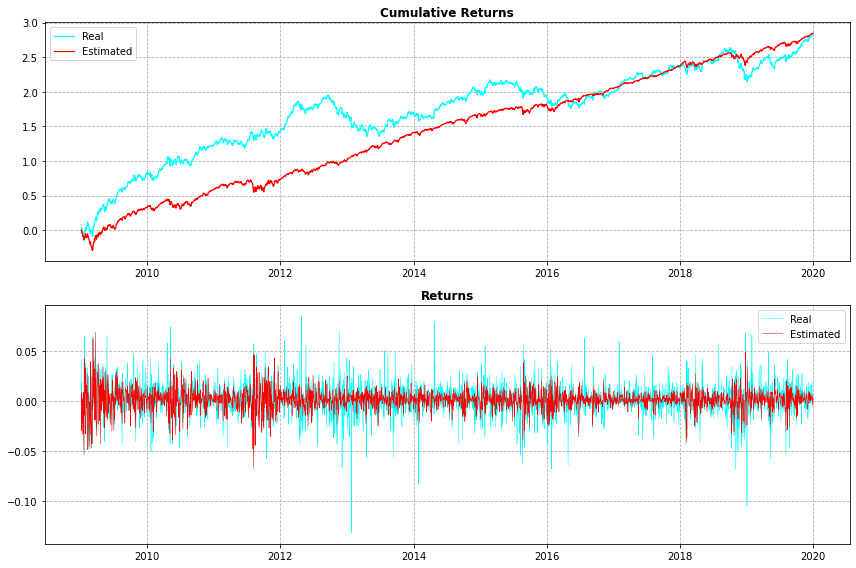

In [17]:
# SUBPLOT - https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# to show figure in an external window
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

axs[0].plot(Y.index, Y.cumsum().to_numpy(), linewidth=1.2, color='cyan')
axs[0].plot(Y_hat.index, Y_hat.cumsum().to_numpy(), linewidth=1.2, color='red')
axs[0].set_title("Cumulative Returns", fontweight='bold')
axs[0].legend(['Real', 'Estimated'], fontsize='medium')
axs[0].grid(linestyle='dashed')

axs[1].plot(Y.index, Y.to_numpy(), linewidth=0.5, color='cyan')
axs[1].plot(Y_hat.index, Y_hat.to_numpy(), linewidth=0.5, color='red')
axs[1].set_title("Returns", fontweight='bold')
axs[1].legend(['Real', 'Estimated'], fontsize='medium')
axs[1].grid(linestyle='dashed')

plt.tight_layout()  # è una funzione di matplotlib che "auto-aggiusta" alcuni settings del vostro grafico. Non è obbligatorio!

Si possono effettuare operazioni matriciali anche passando per oggetti provenienti dalla libreria Numpy. In realtà, la libreria Pandas (standard mondiale per Data Structure, in particolare in finanza (escludendo il caso dei big data)) è costruita sopra alla libreria di Numpy. Troverete quindi molte comunanze tra le due, ad esempio tutte le funzioni di numpy funzionano anche se applicate su oggetti di Pandas. 

Ora trasformiamo i risultati di Pandas in oggetti Numpy (scrivendo alla fine ```to_numpy()```). Questo perchè fare operazioni matriciali con oggetti di Pandas richiede non solo il matching delle dimensioni (righe e colonne) ma anche il matching tra il nome delle righe e delle colonne (cosa molto fastidiosa). Utilizzando Numpy invece, si torna ad operare tra matrici che non hanno nomi per righe e colonne ed è sufficiente il matching tra righe e colonne, ma non tra i nomi.

P.S. all'inizio del Jupyter è stato spiegato come il type che viene scritto dopo ":" e prima di "=" serva solo a specificare la tipologia di oggetto. Notate che ora che siamo passati da oggetti Pandas ad oggetti Numpy (usando `to_numpy()`), la specifica del type dopo i ":" è diventata `np.array`, ovvero un oggetto di Numpy che corrisponde alle nostre matrici/vettori.

In [18]:
TSS: np.array = ((Y-np.mean(Y)).transpose() @ (Y-np.mean(Y))).to_numpy()
ESS: np.array = ((Y_hat-np.mean(Y)).transpose() @ (Y_hat-np.mean(Y))).to_numpy()
res: pd.DataFrame = Y - Y_hat
SSE: np.array = (res.transpose() @ res).to_numpy()
R_2 = ESS/TSS
T: int = X.shape[0]
K: int = X.shape[1]
R_2_adj = 1 - (((T-1)/(T-K))*(1-R_2))
sig_2 = SSE/(T-K)
varcov: np.array = np.linalg.inv(X.transpose() @ X) * sig_2
standard_errors = np.sqrt(np.diag(varcov))

C:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [19]:
coeffs["T-stat"] = coeffs["AAPL"].to_numpy() / standard_errors
coeffs

,AAPL,T-stat
const,0.000680,2.690075
SP500,0.994181,40.380846
EUR_USD,0.029182,0.621787
USD_YEN,0.055324,1.220805


In [20]:
from scipy.stats import t as t_student

t_stat_beta_mkt: float = coeffs.loc["SP500", "T-stat"] 
t_stat_beta_fx: float = coeffs.loc["EUR_USD", "T-stat"]

# test bilaterale     
# test size 5%
critical_value: float = np.abs(t_student.ppf(q=1 - 0.05/2, df=T-K))
    
print('Beta SP500 t-value: ', t_stat_beta_mkt)
print('Beta EUR/USD t-value: ', t_stat_beta_fx)

print('\nCritical Value t-student (a=0.05): ', critical_value)

if t_stat_beta_mkt > critical_value:
    print('\nReject the null-hypothesis. Il Beta di Mercato è statisticamente diverso da 0. Vi è una relazione lineare tra SP500 e AAPL')
else:
    print("\nNot reject the null-hypothesis. Il Beta di Mercato è statisticamente uguale a 0. Non vi è una relazione lineare tra SP500 e AAPL")

Beta SP500 t-value:  40.38084587127951
Beta EUR/USD t-value:  0.6217868977640709

Critical Value t-student (a=0.05):  1.9608229396972119

Reject the null-hypothesis. Il Beta di Mercato è statisticamente diverso da 0. Vi è una relazione lineare tra SP500 e AAPL


In [22]:
# Stima del modello ridotto
X_restricted: pd.DataFrame = X.loc[:, ["const"]]
coeffs_restricted: pd.DataFrame = np.linalg.inv(X_restricted.transpose() @ X_restricted) @ X_restricted.transpose() @ Y
coeffs_restricted.index = X_restricted.columns  # oltre al matching tra (rows, columns) matriciale; deve matchare anche il nome delle righe con quello delle colonne
coeffs_restricted

,AAPL
const,0.001028


In [23]:
Y_hat_restricted: pd.DataFrame = X_restricted @ coeffs_restricted
res_restricted: pd.DataFrame = Y - Y_hat_restricted
SSE_restricted: np.array = (res_restricted.transpose() @ res_restricted).values   # domandare per metodo .to_numpy()

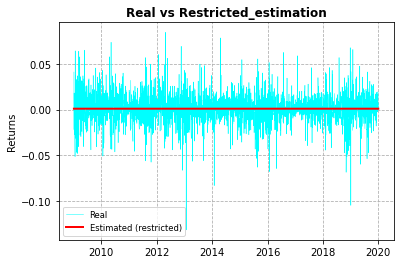

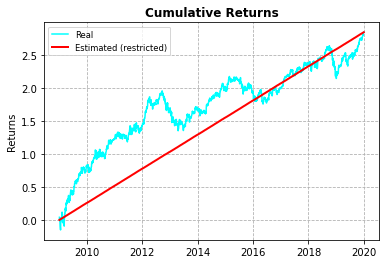

In this case, using Y_hat_restricted that has only the constant term, estimation is basically the mean (try to check if its value is equal to the mean in the above describing table).


In [25]:
%matplotlib inline

plt.figure()
plt.plot(Y.index, Y.to_numpy(), linewidth=0.5, color='cyan')
plt.plot(Y_hat_restricted.index, Y_hat_restricted.to_numpy(), linewidth=2, color='red')
plt.title('Real vs Restricted_estimation', fontweight='bold')
plt.ylabel('Returns')
plt.grid(linestyle='dashed')
plt.legend(['Real', "Estimated (restricted)"], fontsize='small')
plt.show()

%matplotlib inline

plt.figure()
plt.plot(Y.index, Y.cumsum().to_numpy(), color='cyan')
plt.plot(Y_hat_restricted.index, Y_hat_restricted.cumsum().to_numpy(), linewidth=2, color='red')
plt.title('Cumulative Returns', fontweight='bold')
plt.ylabel('Returns')
plt.grid(linestyle='dashed')
plt.legend(['Real', "Estimated (restricted)"], fontsize='small')
plt.show()

print("In this case, using Y_hat_restricted that has only the constant term, estimation is basically the mean (try to check if its value is equal to the mean in the above describing table).")

In [26]:
# F-STAT:
# Ipotesi nulla beta_mkt = beta_EUR_USD = beta_USD_YEN = 0

from scipy.stats import f as f_fisher

F = ((SSE_restricted - SSE)/(K-1))/(SSE/(T-K))
critical_value: float = f_fisher.ppf(0.90, K-1, T-K)
    
print("F-value: ",F[0][0])
print("Critical-value: ", critical_value)

# we reject the null
if F > critical_value:
    print("\nWe Reject the null")
else:
    print("\nWe Not Reject the null")
    

F-value:  543.568350925583
Critical-value:  2.0857775749091774

We Reject the null


### Esercizio:

1. Rifare la regressione su ABI e W500 (sono in grado di farlo senza usare un for infinito ma usando le proprietà matriciali?)
2. Fare forecast per esercizio (in-sample / out-sample)
3. Calcolare Intervallo di Confidenza (IC). Provare a plottare cum-rets usando il Beta risultante da OLS e i beta che assumo valore agli estremi dell'IC. Stiamo visualizzando un intervallo di confidenza della regressione?